# Classification of roads

We're going to look into the success of classifying algorithms on the LiDAR data we have with a couple of different techniques

### The following are the list of classifications defined by IFP
- 0 not yet classified (nothing done yet)
- 1 unclassified (actively marked as nothing)
- 2 ground, sidewalk
- 3,4,5 vegetation, low(gras) medium(shrubbery) high (trees)
- 6 buildings
- 8 street furniture
- 10 street markings
- 11 street, pavement
- 12 bike lanes
- 13 temporary things(bicycles, trashcans)
- 15 cars, trucks

In [1]:
import laspy
import numpy as np
import matplotlib.pyplot as plt     
import seaborn as sns
import open3d as o3d
import pandas as pd
from dotenv import load_dotenv
import json
from upath import UPath
import os
# Load environment variables from .env file if it exists
load_dotenv()
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
from src import data_loader

sns.set_theme(style="whitegrid")

In [2]:
data_loader.fetch_and_process_lidar("riga.laz")

🔍 DEBUG: Attempting to download from: https://b2drop.bsc.es/remote.php/dav/files/james.murphy@bsc.es/REALLOCATE_PE123700/LiDAR_files/riga.laz
✅ Downloaded remote file to ../data/riga.laz
✅ PDAL processed file saved at ../data/riga_filtered.las


PosixPath('../data/riga_filtered.las')

In [2]:
import sys

def las_in_memory_size(las):
    """
    Estimate the in-memory size (in bytes) of a laspy LAS object.
    """
    total_size = 0
    for dim in list(las.point_format.dimension_names):
        arr = getattr(las, dim)
        total_size += arr.nbytes if hasattr(arr, 'nbytes') else sys.getsizeof(arr)
    return total_size

# Example usage:
# las = laspy.read("your_file.las")
# print(f"In-memory size: {las_in_memory_size(las)/1e6:.2f} MB")

def describe_las(las):
    print(f"In-memory size: {las_in_memory_size(las)/1e6:.2f} MB")
    print(f"Point Format: {las.header.point_format}")
    print(f"Number of Points: {las.header.point_count}")
    print("Available Dimensions:", list(las.point_format.dimension_names))
    print("Bounding Box:")
    print(f"  X: {las.header.mins[0]} to {las.header.maxs[0]}")
    print(f"  Y: {las.header.mins[1]} to {las.header.maxs[1]}")
    print(f"  Z: {las.header.mins[2]} to {las.header.maxs[2]}")
    print("Scale:", las.header.scales)
    print("Offset:", las.header.offsets)
    try:
        print("CRS:", las.header.parse_crs())
    except:
        print("CRS: Not defined")

In [3]:
las = laspy.read("../data/bologna_filtered.las")

In [4]:
describe_las(las)

In-memory size: 3834.77 MB
Point Format: <PointFormat(7, 0 bytes of extra dims)>
Number of Points: 112787346
Available Dimensions: ['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'user_data', 'scan_angle', 'point_source_id', 'gps_time', 'red', 'green', 'blue']
Bounding Box:
  X: -319.27 to -107.23
  Y: -315.3 to 26.52
  Z: -8.61 to 34.29
Scale: [0.01 0.01 0.01]
Offset: [0. 0. 0.]
CRS: None


### The las is pretty huge, so we need to sample it up (ensemble)

In [5]:
from laspy import read
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Fields of interest
fields = ['X', 'Y', 'Z', 'intensity', 'red', 'green', 'blue', 'classification']

df = pd.DataFrame({field: np.asarray(getattr(las, field)) for field in fields})

# Optimize data types to reduce memory consumption by ~30%
df['intensity'] = df['intensity'].astype(np.uint16)
df['red'] = df['red'].astype(np.uint16)
df['green'] = df['green'].astype(np.uint16)
df['blue'] = df['blue'].astype(np.uint16)
df['classification'] = df['classification'].astype(np.uint8)  # Only need 0-15 values

print(f"✅ Data loaded with optimized dtypes")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1e9:.2f} GB")


✅ Data loaded with optimized dtypes
Memory usage: 2.37 GB


In [6]:
def make_sample(df, n=2_000_000, seed=None):
    return df.sample(n=n, random_state=seed).reset_index(drop=True)

# NOTE: Don't store all samples in memory at once
# Instead, create them on-demand during training to save ~8GB of RAM
print("✅ Sample function ready. Samples will be created on-demand.")


✅ Sample function ready. Samples will be created on-demand.


## Supervised 

In [7]:
# -------------------------
# 0. Imports
# -------------------------
import pandas as pd
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
random_state = 42
#import tensorflow as tf
#from tensorflow.keras import layers, models
#import joblib

In [26]:
import psutil
import os

def memory_status():
    """Print current memory usage of this notebook and system."""
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    
    print("📊 MEMORY STATUS")
    print("=" * 50)
    print(f"This notebook (RSS): {mem_info.rss / 1e9:.2f} GB")
    print(f"This notebook (VMS): {mem_info.vms / 1e9:.2f} GB")
    
    vm = psutil.virtual_memory()
    print(f"\nSystem memory:")
    print(f"  Total:     {vm.total / 1e9:.2f} GB")
    print(f"  Used:      {vm.used / 1e9:.2f} GB")
    print(f"  Available: {vm.available / 1e9:.2f} GB")
    print(f"  % Used:    {vm.percent:.1f}%")
    
    if vm.percent > 80:
        print("⚠️  Warning: system memory usage is HIGH (>80%)")
    elif vm.percent > 90:
        print("🚨 CRITICAL: system memory usage is VERY HIGH (>90%)")

# Check initial memory state
memory_status()


📊 MEMORY STATUS
This notebook (RSS): 0.10 GB
This notebook (VMS): 468.20 GB

System memory:
  Total:     17.18 GB
  Used:      6.25 GB
  Available: 4.56 GB
  % Used:    73.5%


## Experiment A: Using all of the pointcloud classes


In [8]:
def train_and_eval(X_train, X_test, y_train, y_test, class_weight="balanced", n_estimators=200):
    clf = RandomForestClassifier(n_estimators=n_estimators,
                                 class_weight=class_weight,
                                 n_jobs=-1,
                                 random_state=random_state)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred, digits=3, output_dict=True)
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    return clf, clf.classes_, report, cm

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

def plot_confusion(cm, classes, title="Confusion matrix", normalize=False, cmap="Blues"):
    """
    Plots a confusion matrix, with optional normalization to percentages.

    Args:
        cm (array): confusion matrix (from sklearn.metrics.confusion_matrix)
        classes (list): list of class names
        title (str): plot title
        normalize (bool): if True, show percentages instead of counts
        cmap (str): color map
    """

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        fmt = ".2f"
        title = title + " (normalized %)"
    else:
        fmt = "d"

    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, 
                xticklabels=classes, yticklabels=classes,
                cbar=True, square=True)

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title(title)
    plt.tight_layout()
    plt.show()



🧩 Training model 1/3 on a random 1,000,000 points...


/Users/jamesmurphy/.local/share/uv/python/cpython-3.11.13-macos-aarch64-none/lib/python3.11/multiprocessing/resource_tracker.py:123: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some resources might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '
/Users/jamesmurphy/.local/share/uv/python/cpython-3.11.13-macos-aarch64-none/lib/python3.11/multiprocessing/resource_tracker.py:123: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some resources might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '


✅ Finished model 1/3
              precision    recall  f1-score        support
0              0.831568  0.880641  0.855401  131125.000000
2              0.710808  0.641141  0.674180   22814.000000
5              0.807609  0.772225  0.789521   51788.000000
8              0.687708  0.112134  0.192827    1846.000000
11             0.792826  0.817553  0.805000   31390.000000
13             0.682403  0.193196  0.301136    1646.000000
15             0.676999  0.569801  0.618792    9391.000000
accuracy       0.806528  0.806528  0.806528       0.806528
macro avg      0.741417  0.569527  0.605265  250000.000000
weighted avg   0.802870  0.806528  0.801458  250000.000000


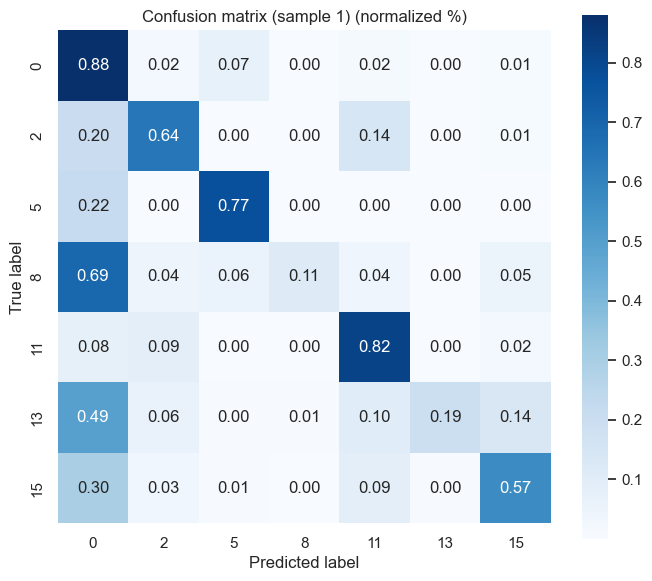


🧩 Training model 2/3 on a random 1,000,000 points...


/Users/jamesmurphy/.local/share/uv/python/cpython-3.11.13-macos-aarch64-none/lib/python3.11/multiprocessing/resource_tracker.py:123: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some resources might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '
/Users/jamesmurphy/.local/share/uv/python/cpython-3.11.13-macos-aarch64-none/lib/python3.11/multiprocessing/resource_tracker.py:123: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some resources might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '
/Users/jamesmurphy/.local/share/uv/python/cpython-3.11.13-macos-aarch64-none/lib/python3.11/multiprocessing/resource_tracker.py:123: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some resources might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '


✅ Finished model 2/3
              precision    recall  f1-score        support
0              0.832288  0.878739  0.854883  131048.000000
2              0.719168  0.649617  0.682626   22738.000000
5              0.802242  0.771913  0.786786   51818.000000
8              0.727564  0.122174  0.209217    1858.000000
11             0.790605  0.819072  0.804587   31438.000000
13             0.707368  0.204007  0.316682    1647.000000
15             0.678549  0.565852  0.617097    9453.000000
accuracy       0.806356  0.806356  0.806356       0.806356
macro avg      0.751112  0.573054  0.610268  250000.000000
weighted avg   0.803116  0.806356  0.801441  250000.000000


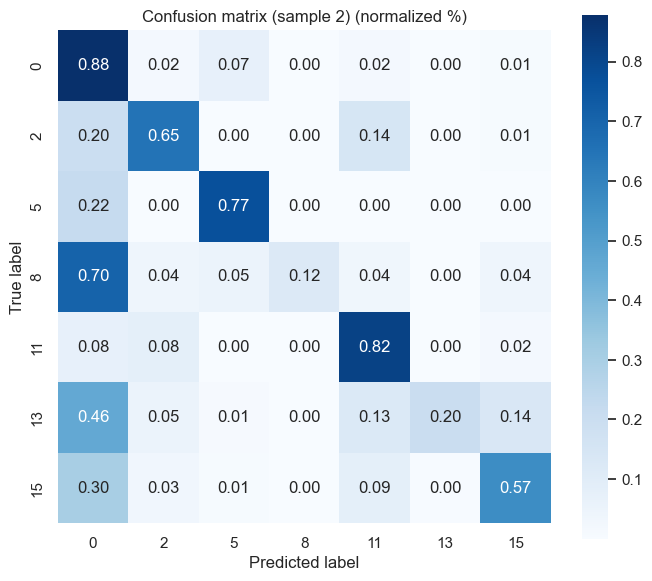


🧩 Training model 3/3 on a random 1,000,000 points...


/Users/jamesmurphy/.local/share/uv/python/cpython-3.11.13-macos-aarch64-none/lib/python3.11/multiprocessing/resource_tracker.py:123: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some resources might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '
/Users/jamesmurphy/.local/share/uv/python/cpython-3.11.13-macos-aarch64-none/lib/python3.11/multiprocessing/resource_tracker.py:123: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some resources might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '
/Users/jamesmurphy/.local/share/uv/python/cpython-3.11.13-macos-aarch64-none/lib/python3.11/multiprocessing/resource_tracker.py:123: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some resources might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '


✅ Finished model 3/3
              precision    recall  f1-score        support
0              0.833076  0.880687  0.856220  130933.000000
2              0.719930  0.651220  0.683853   22831.000000
5              0.805390  0.773083  0.788906   51878.000000
8              0.668693  0.121012  0.204937    1818.000000
11             0.791188  0.821236  0.805932   31466.000000
13             0.752451  0.185386  0.297481    1656.000000
15             0.684374  0.562221  0.617313    9418.000000
accuracy       0.807792  0.807792  0.807792       0.807792
macro avg      0.750729  0.570692  0.607806  250000.000000
weighted avg   0.804394  0.807792  0.802744  250000.000000


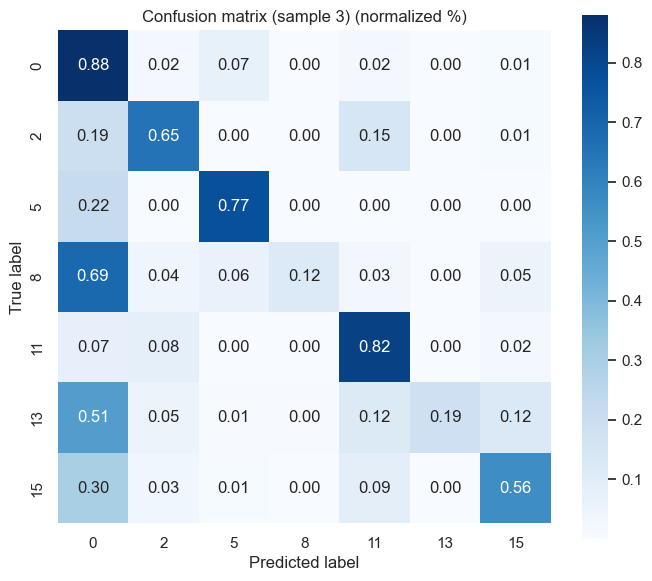

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import gc

# --- Config ---
features = ['Z', 'intensity', 'red', 'green', 'blue'] # take away X and Y as they are likely to differ spatially if applied to different cities.
label_col = 'classification'
n_samples = 1_000_000   # REDUCED: was 2M (saves ~1.5GB per model)
n_models = 3            # how many separate models to train
random_seeds = [42, 101, 202]  # reproducible seeds

results = []

# --- Multi-sample training loop ---
for i, seed in enumerate(random_seeds[:n_models], start=1):
    print(f"\n🧩 Training model {i}/{n_models} on a random {n_samples:,} points...")

    # Sample randomly from the full dataset
    sample_df = df.sample(n=n_samples, random_state=seed)

    # Split
    X = sample_df[features].values
    y = sample_df[label_col].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=seed
    )

    # Train (reuses your function) - REDUCED: 100 estimators instead of 200
    clf, classes, report, cm = train_and_eval(X_train, X_test, y_train, y_test, n_estimators=100)

    # Collect results
    results.append({
        "seed": seed,
        "model": clf,
        "classes": classes,
        "report": report,
        "confusion": cm
    })

    # CLEANUP: Delete intermediate arrays and force garbage collection
    del sample_df, X, y, X_train, X_test, y_train, y_test
    gc.collect()

    print(f"✅ Finished model {i}/{n_models}")
    print(pd.DataFrame(report).T)
    plot_confusion(cm, classes, title=f"Confusion matrix (sample {i})", normalize=True)


In [11]:
# we can also see all of the models' performance together by averaging their reports
all_reports = pd.concat([
    pd.DataFrame(r["report"]).T.assign(seed=r["seed"]) for r in results
])
display(all_reports)

,precision,recall,f1-score,support,seed
0,0.839991,0.882984,0.860951,262451.000000,42
2,0.736266,0.673776,0.703636,45432.000000,42
5,0.808403,0.779758,0.793822,103486.000000,42
8,0.737580,0.157508,0.259583,3676.000000,42
11,0.803668,0.831349,0.817274,62828.000000,42
13,0.713060,0.228258,0.345816,3277.000000,42
15,0.700786,0.590928,0.641186,18850.000000,42
accuracy,0.815486,0.815486,0.815486,0.815486,42
macro avg,0.762822,0.592080,0.631753,500000.000000,42
weighted avg,0.812631,0.815486,0.811192,500000.000000,42


> Sidenote: The thing I've found based on the exploration here is that when X and Y are removed from the equation, there is a DRASTIC reduction in accuracy. The model was hugely leveraging space as a predictive variable. Whilst we can keep this in, it makes it non-transferrable to other locations (unless we normalise and remove the exact geospatial co-ordinate, making each point relative to the points next to it).

> Better yet, we can use the calculated features, such as normals and slope, that Hendrik calculated in the larger pointcloud. Pro is this could improve accuracy for a single model for use in all pointclouds. Trade off is this file is absolutely huge. Still... We can implement all features and trim them off as and when...

## Experiment B: Using a 3 class system (Sidewalk, road, other)

In [7]:
sidewalk_set = {2}
carriageway_set = {11}

def collapse_label(orig):
    if orig in sidewalk_set:
        return "sidewalk"
    elif orig in carriageway_set:
        return "carriageway"
    else:
        return "other"

In [13]:
df["label_3class"] = df["classification"].apply(collapse_label)

In [14]:
df["label_3class"].value_counts()

label_3class
other          88341574
carriageway    14189296
sidewalk       10256476
Name: count, dtype: int64


🧩 Training model 1/3 on a random 2,000,000 points...
✅ Finished model 1/3
              precision    recall  f1-score        support
carriageway    0.969534  0.974534  0.972027   62828.000000
other          0.993029  0.994147  0.993587  391740.000000
sidewalk       0.955157  0.939074  0.947047   45432.000000
accuracy       0.986678  0.986678  0.986678       0.986678
macro avg      0.972573  0.969251  0.970887  500000.000000
weighted avg   0.986635  0.986678  0.986649  500000.000000


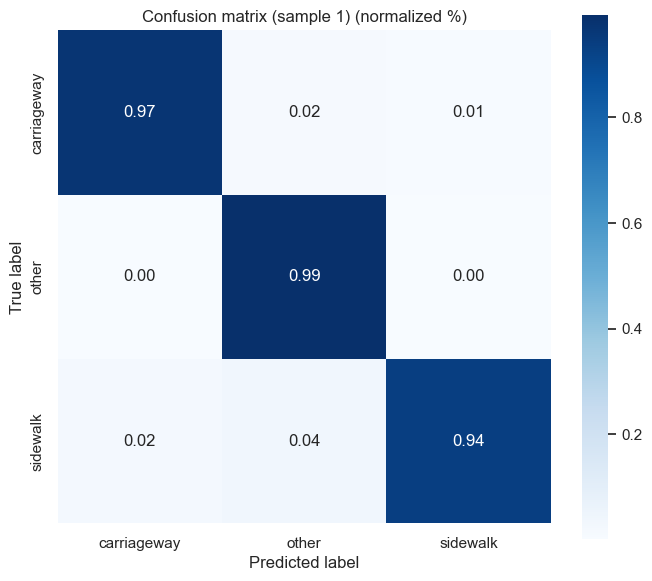


🧩 Training model 2/3 on a random 2,000,000 points...
✅ Finished model 2/3
              precision    recall  f1-score        support
carriageway    0.968127  0.973889  0.970999   62846.000000
other          0.992878  0.994150  0.993513  391788.000000
sidewalk       0.955608  0.937156  0.946292   45366.000000
accuracy       0.986432  0.986432  0.986432       0.986432
macro avg      0.972204  0.968398  0.970268  500000.000000
weighted avg   0.986385  0.986432  0.986399  500000.000000


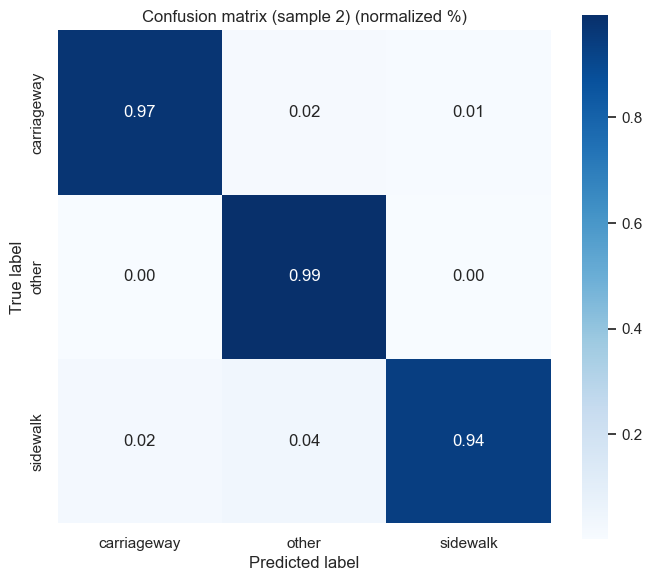


🧩 Training model 3/3 on a random 2,000,000 points...
✅ Finished model 3/3
              precision    recall  f1-score       support
carriageway    0.967935  0.973870  0.970893   62954.00000
other          0.992987  0.994338  0.993662  391586.00000
sidewalk       0.957028  0.937681  0.947256   45460.00000
accuracy       0.986610  0.986610  0.986610       0.98661
macro avg      0.972650  0.968630  0.970604  500000.00000
weighted avg   0.986563  0.986610  0.986576  500000.00000


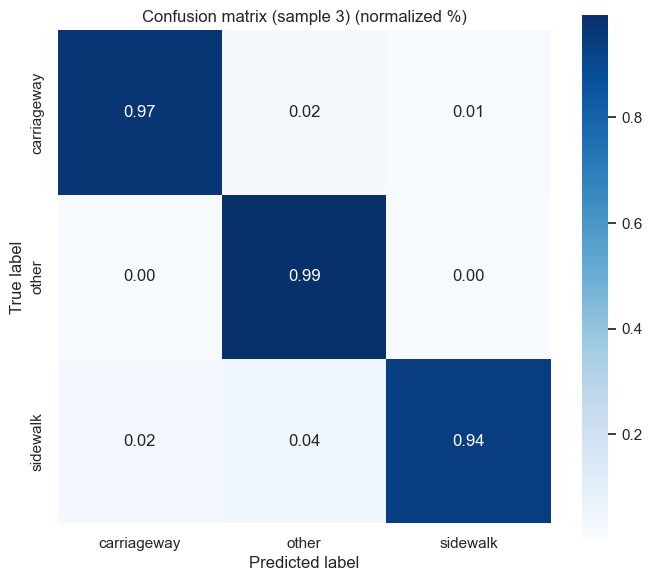

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import gc

# --- Config ---
features = ['X', 'Y', 'Z', 'intensity', 'red', 'green', 'blue']
label_col = 'label_3class'
n_samples = 1_000_000   # REDUCED: was 2M (saves ~1.5GB per model)
n_models = 3            # how many separate models to train
random_seeds = [42, 101, 202]  # reproducible seeds

results_3class = []  # Use different variable name to avoid memory issues

# --- Multi-sample training loop ---
for i, seed in enumerate(random_seeds[:n_models], start=1):
    print(f"\n🧩 Training model {i}/{n_models} on a random {n_samples:,} points...")

    # Sample randomly from the full dataset
    sample_df = df.sample(n=n_samples, random_state=seed)

    # Split
    X = sample_df[features].values
    y = sample_df[label_col].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=seed
    )

    # Train (reuses your function) - REDUCED: 100 estimators instead of 200
    clf, classes, report, cm = train_and_eval(X_train, X_test, y_train, y_test, n_estimators=100)

    # Collect results
    results_3class.append({
        "seed": seed,
        "model": clf,
        "classes": classes,
        "report": report,
        "confusion": cm
    })

    # CLEANUP: Delete intermediate arrays and force garbage collection
    del sample_df, X, y, X_train, X_test, y_train, y_test
    gc.collect()

    print(f"✅ Finished model {i}/{n_models}")
    print(pd.DataFrame(report).T)
    plot_confusion(cm, classes, title=f"Confusion matrix (sample {i})", normalize=True)


## Experiment C: Spatial Validation with Tile-based Split

This experiment tests **transfer learning** by holding out complete spatial tiles from the training set. This simulates deploying the model to a new area of the same city, which is more realistic than random train/test splitting.

**Key question:** Does the model trained on one region work on an unseen spatial region?

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# --- Create spatial tiles (grid-based) ---
# Divide the bounding box into tiles
n_tiles_x = 4  # Create a 4x4 grid
n_tiles_y = 4

x_min, x_max = df['X'].min(), df['X'].max()
y_min, y_max = df['Y'].min(), df['Y'].max()

print(f"Bounding box: X=[{x_min:.1f}, {x_max:.1f}], Y=[{y_min:.1f}, {y_max:.1f}]")

# Create tile assignment using numpy arrays (avoids memory issues)
x_linspace = np.linspace(x_min, x_max, n_tiles_x + 1)
y_linspace = np.linspace(y_min, y_max, n_tiles_y + 1)

tile_x = np.digitize(df['X'].values, x_linspace) - 1
tile_y = np.digitize(df['Y'].values, y_linspace) - 1

# Clip to valid range to handle edge cases
tile_x = np.clip(tile_x, 0, n_tiles_x - 1)
tile_y = np.clip(tile_y, 0, n_tiles_y - 1)

# Create tile IDs as numpy array (efficient)
tile_ids = np.array([f"{tx}_{ty}" for tx, ty in zip(tile_x, tile_y)])

# Count distribution
unique_tiles, counts = np.unique(tile_ids, return_counts=True)
print(f"\n✅ Created {len(unique_tiles)} spatial tiles ({n_tiles_x}x{n_tiles_y} grid)")
print(f"Tile distribution:")
for tile, count in sorted(zip(unique_tiles, counts)):
    print(f"  {tile}: {count:,} points")

# CLEANUP: Delete large tile assignment arrays
del tile_x, tile_y


Bounding box: X=[-31927.0, -10723.0], Y=[-31530.0, 2652.0]

✅ Created 14 spatial tiles (4x4 grid)
Tile distribution:
  0_1: 81,110 points
  0_2: 3,206,084 points
  0_3: 4,381,745 points
  1_0: 346,120 points
  1_1: 11,024,304 points
  1_2: 22,059,380 points
  1_3: 13,858,748 points
  2_0: 12,320,287 points
  2_1: 4,797,738 points
  2_2: 10,404,339 points
  2_3: 18,852,870 points
  3_0: 334,469 points
  3_2: 6,860,766 points
  3_3: 4,259,386 points


In [11]:
# --- Train/test split by spatial tiles ---
# Hold out one tile for testing, train on the rest
features = ['X', 'Y', 'Z', 'intensity', 'red', 'green', 'blue']
label_col = 'classification'

# Select a tile to hold out (e.g., tile 2_2 - center)
test_tile = '2_2'
train_mask = tile_ids != test_tile
test_mask = tile_ids == test_tile

# MEMORY OPTIMIZATION: Use numpy indexing to convert directly to arrays
# This avoids creating dataframe copies
train_indices = np.where(train_mask)[0]
test_indices = np.where(test_mask)[0]

X_train_spatial = df.iloc[train_indices][features].values
y_train_spatial = df.iloc[train_indices][label_col].values

X_test_spatial = df.iloc[test_indices][features].values
y_test_spatial = df.iloc[test_indices][label_col].values

print(f"📍 Spatial Split Configuration:")
print(f"   Training tiles: all except {test_tile}")
print(f"   Training points: {len(train_indices):,}")
print(f"   Test tile: {test_tile}")
print(f"   Test points: {len(test_indices):,}")
print(f"   Test data ratio: {len(test_indices) / len(df) * 100:.1f}%")

print(f"\n✅ Spatial split complete (using numpy arrays to save memory)")
print(f"   Training array shape: {X_train_spatial.shape}")
print(f"   Test array shape: {X_test_spatial.shape}")

# CLEANUP: Delete index arrays and masks
del train_indices, test_indices, train_mask, test_mask


📍 Spatial Split Configuration:
   Training tiles: all except 2_2
   Training points: 102,383,007
   Test tile: 2_2
   Test points: 10,404,339
   Test data ratio: 9.2%

✅ Spatial split complete (using numpy arrays to save memory)
   Training array shape: (102383007, 7)
   Test array shape: (10404339, 7)


In [12]:
import gc

# --- Clean up large dataframes to free memory ---
print("🧹 Cleaning up large dataframes...", flush=True)
print(f"   Deleted: df, tile_ids", flush=True)

del df, tile_ids
gc.collect()

print(f"✅ Memory freed - numpy arrays retained for training", flush=True)
print(f"   Training array shape: {X_train_spatial.shape}", flush=True)
print(f"   Test array shape: {X_test_spatial.shape}", flush=True)


🧹 Cleaning up large dataframes...
   Deleted: df, tile_ids
✅ Memory freed - numpy arrays retained for training
   Training array shape: (102383007, 7)
   Test array shape: (10404339, 7)


### this cell takes a LONG time without HPC

In [15]:
# --- Train model on spatial split ---
import time

print("🧩 Training model on spatial split (all surrounding tiles)...\n")
print(f"   Training set size: {len(X_train_spatial):,} points")
print(f"   Test set size: {len(X_test_spatial):,} points")
print(f"   Features: {len(features)}")
print(f"   Estimators: 200")
print("\n⏳ This may take 5-15 minutes depending on system...\n")

start_time = time.time()

clf_spatial, classes_spatial, report_spatial, cm_spatial = train_and_eval(
    X_train_spatial, X_test_spatial, y_train_spatial, y_test_spatial,
    class_weight="balanced", n_estimators=200
)

elapsed = time.time() - start_time
print(f"\n✅ Training complete in {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")
print("\n📊 Performance on held-out spatial tile:")
print(pd.DataFrame(report_spatial).T)
plot_confusion(cm_spatial, classes_spatial, 
               title=f"Spatial Validation: Test on tile {test_tile}", normalize=True)

🧩 Training model on spatial split (all surrounding tiles)...



/Users/jamesmurphy/.local/share/uv/python/cpython-3.11.13-macos-aarch64-none/lib/python3.11/multiprocessing/resource_tracker.py:123: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some resources might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '


KeyboardInterrupt: 

### Run this cell instead

🧩 FASTER: Training model on SAMPLED spatial split...

   Sampling training data...
   Sampled training set: 999,519 points (from 102,383,007)
   Full test set: 10,404,339 points
   Features: 7
   Estimators: 100 (reduced for speed)

⏳ This should take 2-5 minutes...



/Users/jamesmurphy/.local/share/uv/python/cpython-3.11.13-macos-aarch64-none/lib/python3.11/multiprocessing/resource_tracker.py:123: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some resources might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '
/Users/jamesmurphy/.local/share/uv/python/cpython-3.11.13-macos-aarch64-none/lib/python3.11/multiprocessing/resource_tracker.py:123: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some resources might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '
/Users/jamesmurphy/.local/share/uv/python/cpython-3.11.13-macos-aarch64-none/lib/python3.11/multiprocessing/resource_tracker.py:123: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some resources might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '
/Users/jamesmurphy/Documents/GitHub/lidar_sidewalks/.venv/lib/python3.11/site-packages/sklearn/metrics/_classifi


✅ Training complete in 45.3 seconds (0.8 minutes)

📊 Performance on held-out spatial tile:
              precision    recall  f1-score       support
0              0.754631  0.873215  0.809604  5.072981e+06
2              0.799817  0.333115  0.470339  3.576540e+05
5              0.836992  0.830083  0.833523  4.080960e+06
8              0.077926  0.007308  0.013364  9.810500e+04
11             0.933968  0.484597  0.638107  4.925100e+05
13             0.000000  0.000000  0.000000  1.009460e+05
15             0.640925  0.233206  0.341979  2.011830e+05
accuracy       0.790322  0.790322  0.790322  7.903224e-01
macro avg      0.577751  0.394504  0.443845  1.040434e+07
weighted avg   0.781077  0.790322  0.774800  1.040434e+07


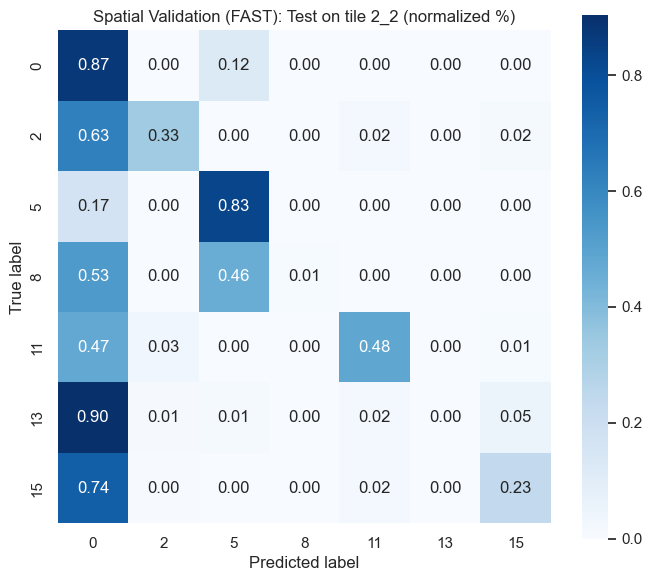

In [13]:
# --- FASTER VERSION: Train on sampled data ---
# This is much faster while still being statistically valid
import time
import sys

print("🧩 FASTER: Training model on SAMPLED spatial split...\n", flush=True)

# Sample training data for faster training (still statistically sound)
print("   Sampling training data...", flush=True)
sample_size = 1_000_000  # Use 1M points instead of all
sample_fraction = min(1.0, sample_size / len(X_train_spatial))
train_mask = np.random.RandomState(42).rand(len(X_train_spatial)) < sample_fraction
X_train_sample = X_train_spatial[train_mask]
y_train_sample = y_train_spatial[train_mask]

print(f"   Sampled training set: {len(X_train_sample):,} points (from {len(X_train_spatial):,})", flush=True)
print(f"   Full test set: {len(X_test_spatial):,} points", flush=True)
print(f"   Features: {len(features)}", flush=True)
print(f"   Estimators: 100 (reduced for speed)", flush=True)
print("\n⏳ This should take 2-5 minutes...\n", flush=True)

start_time = time.time()

clf_spatial_fast, classes_spatial_fast, report_spatial_fast, cm_spatial_fast = train_and_eval(
    X_train_sample, X_test_spatial, y_train_sample, y_test_spatial,
    class_weight="balanced", n_estimators=100
)

elapsed = time.time() - start_time
print(f"\n✅ Training complete in {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)", flush=True)
print("\n📊 Performance on held-out spatial tile:", flush=True)
print(pd.DataFrame(report_spatial_fast).T)
plot_confusion(cm_spatial_fast, classes_spatial_fast, 
               title=f"Spatial Validation (FAST): Test on tile {test_tile}", normalize=True)

# Store for comparison
report_spatial = report_spatial_fast
cm_spatial = cm_spatial_fast

In [17]:
results[0]

{'seed': 42,
 'model': RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42),
 'classes': array([ 0,  2,  5,  8, 11, 13, 15], dtype=uint8),
 'report': {'0': {'precision': 0.8315678042387101,
   'recall': 0.8806406101048617,
   'f1-score': 0.8554009807843311,
   'support': 131125.0},
  '2': {'precision': 0.7108076586645933,
   'recall': 0.6411414044008065,
   'f1-score': 0.6741795722713865,
   'support': 22814.0},
  '5': {'precision': 0.8076092005088956,
   'recall': 0.7722252259210628,
   'f1-score': 0.7895209610392174,
   'support': 51788.0},
  '8': {'precision': 0.6877076411960132,
   'recall': 0.11213434452871072,
   'f1-score': 0.19282720074522589,
   'support': 1846.0},
  '11': {'precision': 0.7928264697704593,
   'recall': 0.8175533609429755,
   'f1-score': 0.8050000784203014,
   'support': 31390.0},
  '13': {'precision': 0.6824034334763949,
   'recall': 0.19319562575941676,
   'f1-score': 0.30113636363636365,
   'support': 1646.0},
  '15': {'precision': 0.6

In [19]:
report_spatial

{'0': {'precision': 0.7546307503320607,
  'recall': 0.8732151766387456,
  'f1-score': 0.8096036768964526,
  'support': 5072981.0},
 '2': {'precision': 0.799817399418632,
  'recall': 0.33311524546069665,
  'f1-score': 0.47033929251716794,
  'support': 357654.0},
 '5': {'precision': 0.8369919696546292,
  'recall': 0.830082872657414,
  'f1-score': 0.833523103975981,
  'support': 4080960.0},
 '8': {'precision': 0.07792631235735246,
  'recall': 0.0073084959991845475,
  'f1-score': 0.01336365161314372,
  'support': 98105.0},
 '11': {'precision': 0.9339680601699127,
  'recall': 0.48459726706056727,
  'f1-score': 0.6381071929395377,
  'support': 492510.0},
 '13': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 100946.0},
 '15': {'precision': 0.6409251113357558,
  'recall': 0.23320558894141155,
  'f1-score': 0.3419793356050804,
  'support': 201183.0},
 'accuracy': 0.7903223837670034,
 'macro avg': {'precision': 0.5777513718954775,
  'recall': 0.3945035209654314,
  'f1-score': 0.44

In [23]:
class_name

np.uint8(15)

In [24]:
# --- Compare: Random vs Spatial Split ---
print("=" * 70)
print("COMPARISON: Random Split vs Spatial Split")
print("=" * 70)

# Extract accuracy metrics from both experiments
random_split_results = results[0]  # From Experiment A (all classes)
spatial_split_report = report_spatial

# Compare accuracy for each class
print("\n🎯 Overall Accuracy:")
print(f"   Random split (Exp A):  {random_split_results['report']['accuracy']:.4f}")
print(f"   Spatial split (Exp C): {spatial_split_report['accuracy']:.4f}")

print("\n📈 Per-class F1-scores:")
# Iterate over keys in the report that are class labels (stored as strings)
for key in random_split_results['report'].keys():
    # Skip non-numeric keys like 'accuracy', 'macro avg', 'weighted avg', etc.
    try:
        class_label = int(key)  # Try to convert string key to int
        # Now check both the string key and int key in the spatial report
        if key in spatial_split_report:
            random_f1 = random_split_results['report'][key]['f1-score']
            spatial_f1 = spatial_split_report[key]['f1-score']
            diff = spatial_f1 - random_f1
            symbol = "📉" if diff < -0.05 else "📈" if diff > 0.05 else "➡️"
            print(f"   Class {class_label:2} | Random: {random_f1:.3f} | Spatial: {spatial_f1:.3f} | Δ {diff:+.3f} {symbol}")
    except (ValueError, KeyError):
        # Skip keys that can't be converted to int or aren't in spatial report
        pass

print("\n💡 Interpretation:")
print("   • If spatial performance is similar → model generalizes well to unseen regions")
print("   • If spatial performance drops significantly → model is overfitting to local patterns")
print("   • Spatial validation is more realistic for deployment to new areas")


COMPARISON: Random Split vs Spatial Split

🎯 Overall Accuracy:
   Random split (Exp A):  0.8065
   Spatial split (Exp C): 0.7903

📈 Per-class F1-scores:
   Class  0 | Random: 0.855 | Spatial: 0.810 | Δ -0.046 ➡️
   Class  2 | Random: 0.674 | Spatial: 0.470 | Δ -0.204 📉
   Class  5 | Random: 0.790 | Spatial: 0.834 | Δ +0.044 ➡️
   Class  8 | Random: 0.193 | Spatial: 0.013 | Δ -0.179 📉
   Class 11 | Random: 0.805 | Spatial: 0.638 | Δ -0.167 📉
   Class 13 | Random: 0.301 | Spatial: 0.000 | Δ -0.301 📉
   Class 15 | Random: 0.619 | Spatial: 0.342 | Δ -0.277 📉

💡 Interpretation:
   • If spatial performance is similar → model generalizes well to unseen regions
   • If spatial performance drops significantly → model is overfitting to local patterns
   • Spatial validation is more realistic for deployment to new areas


### This cell checks for tile contiguity and computes mean tile parameters for each class

**Motivation:** We've found that random selection of tiles for training the model actually moderately increases accuracy. Now this could be because we´re currently just taking a sample of 1m and may change if we're using all of them. This is why we're going to take the radioetric properties of each contiguous cell, because if we have a random sample across the pointcloud, we might be creating a more general model, rather than a localised one.

🧭 Running quick spatial contiguity plot (may sample up to 200k points)...


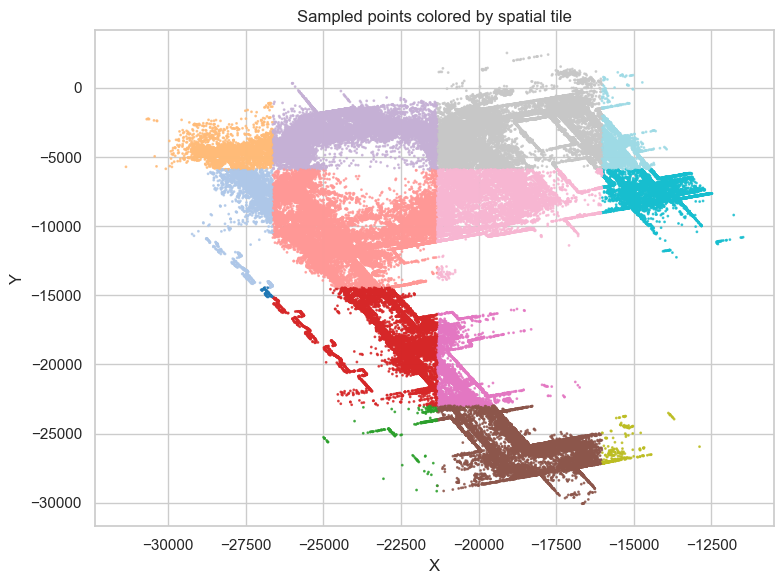


📊 Computing per-tile radiometrics (train)...
      intensity           red         green          blue
tile                                                     
0_1   48.288016  27883.071187  24439.222587  23578.521613
0_2   36.700922  20053.118888  18812.981978  17731.951527
0_3   26.803440  30447.488792  29254.970228  29140.057689
1_0   51.477554  35769.037883  27512.546770  25160.382203
1_1   44.400710  26717.110187  24740.128885  23224.683395
1_2   32.909370  27910.614455  26360.856575  25055.963241
1_3   35.858049  29590.464589  28556.789870  27029.922137
2_0   41.414622  26984.062116  23567.979680  21814.932331
2_1   44.239400  28493.121890  25700.470387  23934.192535
2_3   36.275426  29356.140065  26768.970162  24970.344546
3_0   34.766902  28102.189154  25383.743761  22743.728118
3_2   55.552992  30656.464163  27321.949504  24386.426635
3_3   56.415598  27475.012753  24214.451912  21666.282560

📊 Computing per-tile radiometrics (test)...
      intensity           red         g

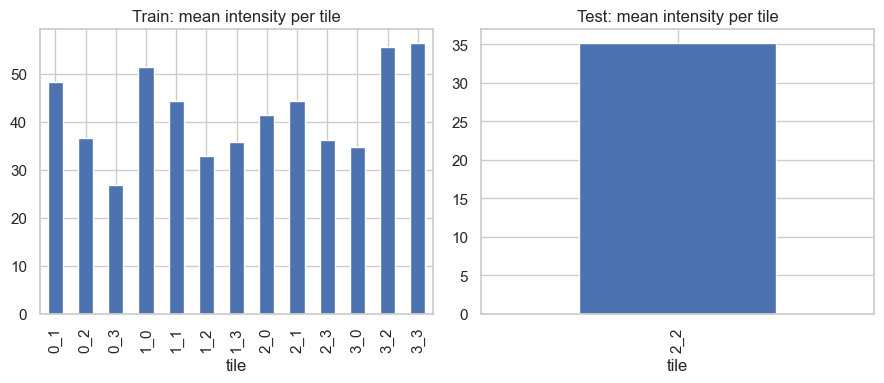


🧠 Preparing SHAP analysis helpers (will sample up to 5000 rows).

🔎 SHAP for random (global) model — this may take a minute
✖ shap not installed or failed to import. Install with `pip install shap` to run SHAP analysis.

🔎 SHAP for spatial model (fast) — this may take a minute
✖ shap not installed or failed to import. Install with `pip install shap` to run SHAP analysis.

✅ Diagnostics and helpers added. Examples:
  - plot_tile_samples(sample_size=50000)
  - plot_tile_2d('1_1', which='train')
  - plot_tile_3d_open3d('2_2', which='test')
  - run_shap_for_model(clf, np.vstack([X_train_spatial, X_test_spatial])[:,3:], ['intensity','red','green','blue'])  # model on radiometric features only


6878

In [25]:
# --- Diagnostics: tiles, radiometrics, SHAP analysis, and plotting helpers ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

# Assumptions:
# - `X_train_spatial`, `X_test_spatial` are numpy arrays with columns [X, Y, Z, intensity, red, green, blue]
# - `report_spatial` and `results` exist from earlier cells
# - `clf` (random model) and `clf_spatial_fast` exist if you ran both training cells

feature_names = ['X', 'Y', 'Z', 'intensity', 'red', 'green', 'blue']

# 1) Reconstruct tile grid from combined spatial arrays (safe if `df` was deleted)
all_XY = np.vstack([X_train_spatial[:, :2], X_test_spatial[:, :2]])

n_tiles_x = globals().get('n_tiles_x', 4)
n_tiles_y = globals().get('n_tiles_y', 4)

x_min, x_max = all_XY[:,0].min(), all_XY[:,0].max()
y_min, y_max = all_XY[:,1].min(), all_XY[:,1].max()

x_linspace = np.linspace(x_min, x_max, n_tiles_x + 1)
y_linspace = np.linspace(y_min, y_max, n_tiles_y + 1)

# helper to compute tile ids for an XY array
def compute_tile_ids(xy):
    tx = np.digitize(xy[:,0], x_linspace) - 1
    ty = np.digitize(xy[:,1], y_linspace) - 1
    tx = np.clip(tx, 0, n_tiles_x - 1)
    ty = np.clip(ty, 0, n_tiles_y - 1)
    return np.array([f"{a}_{b}" for a,b in zip(tx, ty)])

# Compute tile_ids for train and test arrays
tile_ids_train = compute_tile_ids(X_train_spatial[:, :2])
tile_ids_test = compute_tile_ids(X_test_spatial[:, :2])

# Quick contiguity check: plot a small sample colored by tile id
def plot_tile_samples(sample_size=200000):
    import matplotlib.pyplot as plt
    # sample from combined XY
    total = len(tile_ids_train) + len(tile_ids_test)
    sample_size = min(sample_size, total)
    # sample proportionally from train and test
    n_train = int(sample_size * (len(tile_ids_train)/total))
    n_test = sample_size - n_train

    idx_train = np.random.RandomState(0).choice(len(tile_ids_train), n_train, replace=False) if n_train>0 else np.array([], dtype=int)
    idx_test = np.random.RandomState(1).choice(len(tile_ids_test), n_test, replace=False) if n_test>0 else np.array([], dtype=int)

    XY_sample = np.vstack([X_train_spatial[idx_train, :2] if n_train>0 else np.zeros((0,2)),
                           X_test_spatial[idx_test, :2] if n_test>0 else np.zeros((0,2))])
    tile_sample = np.concatenate([tile_ids_train[idx_train] if n_train>0 else np.array([], dtype=object),
                                  tile_ids_test[idx_test] if n_test>0 else np.array([], dtype=object)])

    # map tile ids to integer colors
    unique_tiles = np.unique(tile_sample)
    tile_to_int = {t:i for i,t in enumerate(unique_tiles)}
    colors = np.array([tile_to_int[t] for t in tile_sample])

    plt.figure(figsize=(8,6))
    sc = plt.scatter(XY_sample[:,0], XY_sample[:,1], c=colors, s=1, cmap='tab20', alpha=0.8)
    plt.title('Sampled points colored by spatial tile')
    plt.xlabel('X'); plt.ylabel('Y')
    plt.tight_layout()
    plt.show()

print('🧭 Running quick spatial contiguity plot (may sample up to 200k points)...')
plot_tile_samples(sample_size=100000)

# 2) Per-tile radiometrics: compute mean intensity and colors for each tile (train + test separately)

def per_tile_radiometrics(X_arr, tile_ids_arr):
    df_r = pd.DataFrame({
        'tile': tile_ids_arr,
        'intensity': X_arr[:,3].astype(float),
        'red': X_arr[:,4].astype(float),
        'green': X_arr[:,5].astype(float),
        'blue': X_arr[:,6].astype(float)
    })
    grouped = df_r.groupby('tile').mean()
    return grouped.sort_index()

print('\n📊 Computing per-tile radiometrics (train)...')
train_radiom = per_tile_radiometrics(X_train_spatial, tile_ids_train)
print(train_radiom)

print('\n📊 Computing per-tile radiometrics (test)...')
test_radiom = per_tile_radiometrics(X_test_spatial, tile_ids_test)
print(test_radiom)

# Plot intensity differences across tiles
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
train_radiom['intensity'].plot(kind='bar'); plt.title('Train: mean intensity per tile')
plt.subplot(1,2,2)
test_radiom['intensity'].plot(kind='bar'); plt.title('Test: mean intensity per tile')
plt.tight_layout(); plt.show()

# 3) SHAP analysis helpers (trees only). Uses small sample to limit RAM.
print('\n🧠 Preparing SHAP analysis helpers (will sample up to 5000 rows).')

def run_shap_for_model(model, X_array, feature_names, sample_size=5000):
    try:
        import shap
    except Exception as e:
        print('✖ shap not installed or failed to import. Install with `pip install shap` to run SHAP analysis.')
        return None

    n = min(sample_size, len(X_array))
    idx = np.random.RandomState(0).choice(len(X_array), n, replace=False)
    X_sample = X_array[idx]

    # Use TreeExplainer for tree-based models
    try:
        explainer = shap.TreeExplainer(model)
    except Exception as e:
        print('✖ TreeExplainer failed:', e)
        return None

    shap_values = explainer.shap_values(X_sample)

    # shap_values for multiclass is a list; convert to mean absolute across classes
    if isinstance(shap_values, list):
        # compute mean absolute shap across classes for each feature
        abs_mean = np.mean([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)
        feature_imp = pd.Series(abs_mean, index=feature_names).sort_values(ascending=False)
    else:
        feature_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=feature_names).sort_values(ascending=False)

    # Summary plot (may be slow) — show if interactive
    try:
        shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=True)
    except Exception:
        pass

    return feature_imp

# Run SHAP for random model (if available)
if 'clf' in globals():
    print('\n🔎 SHAP for random (global) model — this may take a minute')
    imp_random = run_shap_for_model(clf, np.vstack([X_train_spatial, X_test_spatial]), feature_names, sample_size=3000)
    if imp_random is not None:
        print('\nFeature importance (random model):')
        print(imp_random)

if 'clf_spatial_fast' in globals():
    print('\n🔎 SHAP for spatial model (fast) — this may take a minute')
    imp_spatial = run_shap_for_model(clf_spatial_fast, np.vstack([X_train_spatial, X_test_spatial]), feature_names, sample_size=3000)
    if imp_spatial is not None:
        print('\nFeature importance (spatial model):')
        print(imp_spatial)

# 4) Tile plotting helpers: 2D scatter and optional Open3D 3D viewer

def plot_tile_2d(tile_id, which='train', sample=50000):
    if which == 'train':
        Xarr, tids = X_train_spatial, tile_ids_train
    else:
        Xarr, tids = X_test_spatial, tile_ids_test
    mask = (tids == tile_id)
    if mask.sum() == 0:
        print(f'No points for tile {tile_id} in {which}')
        return
    idx = np.where(mask)[0]
    n = min(sample, len(idx))
    sel = np.random.RandomState(0).choice(idx, n, replace=False)
    XY = Xarr[sel, :2]
    plt.figure(figsize=(6,5))
    plt.scatter(XY[:,0], XY[:,1], s=1)
    plt.title(f'Tile {tile_id} ({which}) — {n} points')
    plt.xlabel('X'); plt.ylabel('Y')
    plt.show()

def plot_tile_3d_open3d(tile_id, which='train', sample=100000):
    try:
        import open3d as o3d
    except Exception as e:
        print('Open3D not available.')
        return
    if which == 'train':
        Xarr, tids = X_train_spatial, tile_ids_train
    else:
        Xarr, tids = X_test_spatial, tile_ids_test
    mask = (tids == tile_id)
    if mask.sum() == 0:
        print(f'No points for tile {tile_id} in {which}')
        return
    idx = np.where(mask)[0]
    n = min(sample, len(idx))
    sel = np.random.RandomState(0).choice(idx, n, replace=False)
    pts = Xarr[sel, :3]
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts)
    o3d.visualization.draw_geometries([pcd], window_name=f'Tile {tile_id} ({which})')

print('\n✅ Diagnostics and helpers added. Examples:')
print("  - plot_tile_samples(sample_size=50000)")
print("  - plot_tile_2d('1_1', which='train')")
print("  - plot_tile_3d_open3d('2_2', which='test')")
print("  - run_shap_for_model(clf, np.vstack([X_train_spatial, X_test_spatial])[:,3:], ['intensity','red','green','blue'])  # model on radiometric features only")

gc.collect()


## Interactive viewing of model labels (predicted and True)

In [ ]:
import open3d as o3d
import numpy as np
import gc

# MEMORY NOTE: This cell uses X_test_spatial which is already loaded
# Create a visualization sample to avoid loading too much data
print("Creating visualization sample (100k points)...", flush=True)

# Sample indices from the test set 
sample_indices = np.random.RandomState(42).choice(len(X_test_spatial), 
                                                   min(100_000, len(X_test_spatial)), 
                                                   replace=False)
X_plot = X_test_spatial[sample_indices]

# get predicted labels from the trained model
y_pred = clf_spatial_fast.predict(X_plot)

# convert numeric codes to strings
class_map = {
    1: "carriageway",
    2: "sidewalk",
    3: "other",
    11: "carriageway",
    "carriageway": "carriageway",
    "sidewalk": "sidewalk",
    "other": "other"
}
labels = pd.Series(y_pred).map(class_map).fillna("other")

# assign RGB colors per predicted class
color_map = {
    "carriageway": [0.6, 0.6, 0.6],  # grey
    "sidewalk": [1.0, 0.5, 0.1],     # orange
    "other": [0.3, 0.8, 0.3]         # green
}
colors = np.array([color_map[lbl] for lbl in labels])

# create point cloud for visualization
# Extract X, Y, Z from the feature array
pcd_pred = o3d.geometry.PointCloud()
pcd_pred.points = o3d.utility.Vector3dVector(X_plot[:, :3])  # First 3 columns are X, Y, Z
pcd_pred.colors = o3d.utility.Vector3dVector(colors)

# visualize
o3d.visualization.draw_geometries([pcd_pred], window_name="Predicted Labels")

# CLEANUP: Free memory after visualization
del X_plot, y_pred, colors, labels, pcd_pred, sample_indices
gc.collect()
print("✅ Visualization complete and memory cleaned up", flush=True)
